
--- 正在绘制 图1: 原始时序图 ---


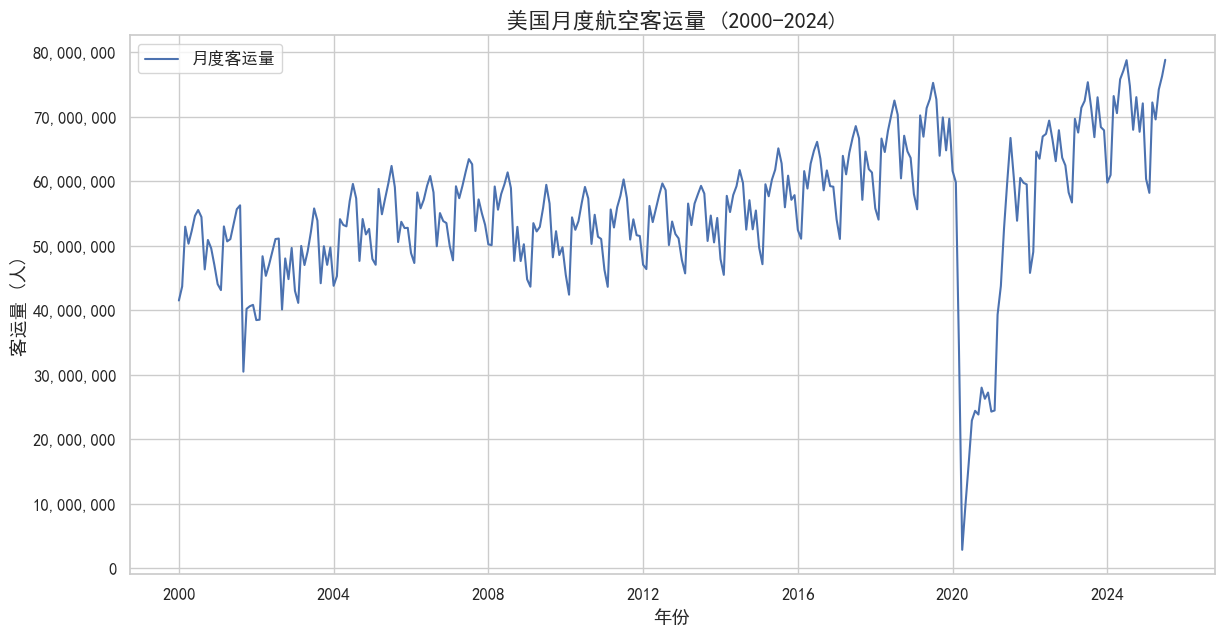


--- 步骤 3: 正在拟合 SARIMA(1,1,1)x(1,1,0,12) 模型... ---


c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                          passengers   No. Observations:                  307
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -4673.632
Date:                             Fri, 31 Oct 2025   AIC                           9355.265
Time:                                     14:40:07   BIC                           9369.818
Sample:                                 01-01-2000   HQIC                          9361.101
                                      - 07-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1207      0.116      1.043      0.297      -0.106       0.348
ma.L1          0.2667      

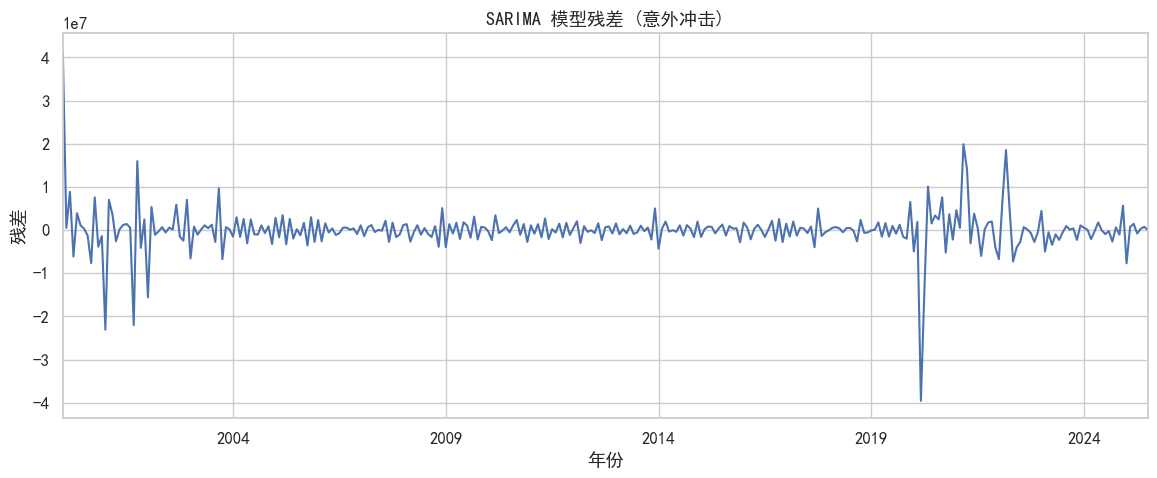


--- 步骤 4.1: 对SARIMA残差进行 ARCH-LM 检验 ---
ARCH-LM 检验统计量: 50.429584208302465
ARCH-LM 检验 p-value: 1.1740783709910175e-06
F-statistic (for test): 4.845619716754549
F-statistic p-value: 2.9838748763211814e-07
结论: p值 < 0.05，拒绝原假设。残差中存在显著的 ARCH 效应。

--- 步骤 4.2: 拟合 GARCH(1,1) 模型 (波动率方程)... ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6471.20
Distribution:                  Normal   AIC:                           12950.4
Method:            Maximum Likelihood   BIC:                           12965.3
                                        No. Observations:                  307
Date:                Fri, Oct 31 2025   Df Residuals:                      306
Time:                        14:40:07   Df Model:                            1
   

C:\Windows\Temp\ipykernel_14500\3161254781.py:65: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test_results = het_arch(residuals, maxlag=12)


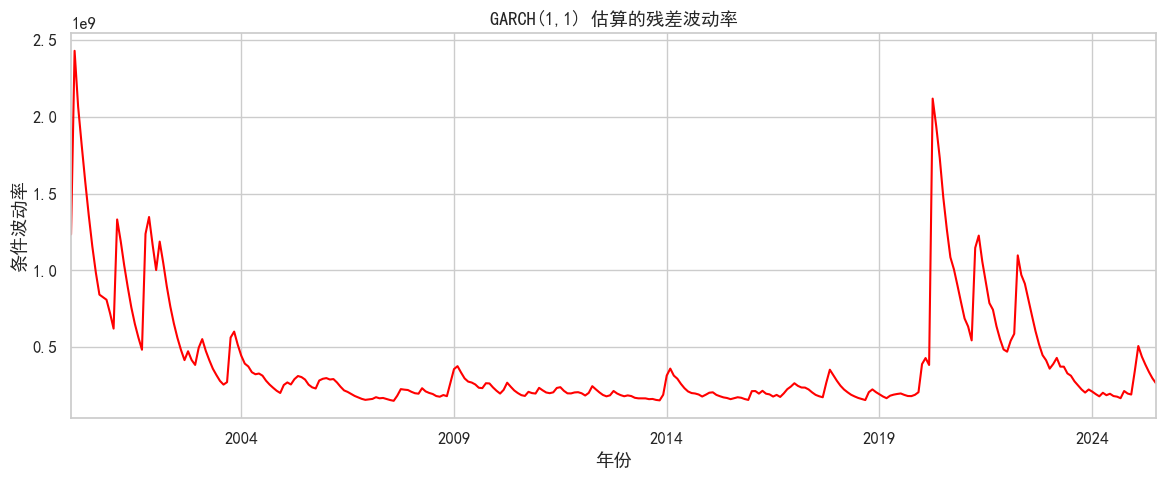


--- 全部分析完成 ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
import warnings

def run_airline_volatility_analysis():
    # 使用 StringIO 将字符串模拟成一个文件，然后用pandas读取
    # --- 数据加载 ---
    data = pd.read_csv('ENPLANED.csv', index_col='observation_date', parse_dates=True)

    # --- 数据预处理 ---
    data.rename(columns={'ENPLANED': 'passengers'}, inplace=True)                                                                 
    # FRED数据单位是千人 (Thousands of Persons)，我们将其转换为实际人数
    data['passengers'] = data['passengers'] * 1000
    
    # --- 步骤 2: 探索性数据分析 (EDA) ---
    print("\n--- 正在绘制 图1: 原始时序图 ---")
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['passengers'], label='月度客运量')
    plt.title('美国月度航空客运量 (2000-2024)', fontsize=16)
    plt.xlabel('年份')
    plt.ylabel('客运量 (人)')
    plt.legend()
    plt.grid(True)
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ','))
    )
    plt.show()

    # --- 步骤 3: 拟合 SARIMA (均值方程) ---
    print("\n--- 步骤 3: 正在拟合 SARIMA(1,1,1)x(1,1,0,12) 模型... ---")
    # (1,1,1)处理非季节性部分, (1,1,0,12)处理季节性部分
    sarima_model = SARIMAX(data['passengers'],
                           order=(1, 1, 1),
                           seasonal_order=(1, 1, 0, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    
    sarima_results = sarima_model.fit(disp=False)
    print(sarima_results.summary())
    
    # 提取标准化残差
    residuals = sarima_results.resid
    # 标准化残差 (通常 GARCH 分析使用标准化残差，但这里用原始残差影响不大)
    # residuals = sarima_results.resid / sarima_results.conditional_volatility
    
    print("\n--- 正在绘制 图2: SARIMA模型标准化残差 ---")
    plt.figure(figsize=(14, 5))
    residuals.plot(title="SARIMA 模型残差 (意外冲击)")
    plt.xlabel('年份')
    plt.ylabel('残差')
    plt.grid(True)
    plt.show()

    # --- 步骤 4: 波动率分析 (GARCH) ---
    
    print("\n--- 步骤 4.1: 对SARIMA残差进行 ARCH-LM 检验 ---")
    # 原假设: 不存在 ARCH 效应
    # 我们使用 12 个滞后 (对应12个月)
    arch_test_results = het_arch(residuals, maxlag=12)
    print(f"ARCH-LM 检验统计量: {arch_test_results[0]}")
    print(f"ARCH-LM 检验 p-value: {arch_test_results[1]}")
    print(f"F-statistic (for test): {arch_test_results[2]}")
    print(f"F-statistic p-value: {arch_test_results[3]}")
    
    if arch_test_results[1] < 0.05:
        print("结论: p值 < 0.05，拒绝原假设。残差中存在显著的 ARCH 效应。")
    else:
        print("结论: p值 > 0.05，不能拒绝原假设。残差中没有显著的 ARCH 效应。")
        
    # --- 步骤 4.2: 对残差拟合 GARCH(1,1) 模型 ---
    print("\n--- 步骤 4.2: 拟合 GARCH(1,1) 模型 (波动率方程)... ---")
    # 乘以100使数值更稳定，是GARCH拟合的常见做法
    garch_model = arch_model(residuals * 100, vol='Garch', p=1, q=1, dist='Normal')
    
    # 拟合GARCH模型
    # 忽略收敛警告，因为我们知道数据可能没有GARCH效应
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        garch_results = garch_model.fit(disp='off')
        
    print(garch_results.summary())
    
    # --- 步骤 4.3: 可视化残差的条件波动率 ---
    print("\n--- 正在绘制 图3: GARCH(1,1) 估算的残差波动率 ---")
    
    conditional_volatility = garch_results.conditional_volatility
    
    plt.figure(figsize=(14, 5))
    conditional_volatility.plot(title="GARCH(1,1) 估算的残差波动率", color='red')
    plt.xlabel('年份')
    plt.ylabel('条件波动率')
    plt.grid(True)
    plt.show()

    print("\n--- 全部分析完成 ---")

if __name__ == "__main__":
    # 设置全局绘图风格
    sns.set_theme(style="whitegrid", font_scale=1.1)
    # 解决matplotlib中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 'SimHei' 是黑体
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
    
    run_airline_volatility_analysis()
